In [373]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy import optimize

In [374]:
def set_size(width, fraction=1, shape=(1,1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    if shape != (1,1):
            golden_ratio = 1/2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    shape_ratio = shape[0] / shape[1]
    fig_height_in = fig_height_in * shape_ratio

    fig_dim = (fig_width_in , fig_height_in)

    return fig_dim


In [375]:
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
     'axes.unicode_minus': False
})

In [376]:
threshold_path = 'GMA Data/Threshold Determination Data/'
figure_path = '../tex/61b131aa6c2c24ed40fb5c29/figures/'

In [377]:
crystals = ['BGO', 'CsI', 'LYSO']
sources = ['Am-241', 'Cs-137', 'Na-22', 'Co-60 RO15', 'Co-60 LE859',]
BGO_dates = ['27-07-21',  '27-07-21', '30-07-21', '30-07-21']
CSI_dates = ['27-07-21', '27-07-21', '29-07-21', '29-07-21']
LYSO_dates = ['27-07-21', '27-07-21', '29-07-21', '28-07-21', '28-07-21']
crystals_dates = [BGO_dates, CSI_dates, LYSO_dates]
no_source_name = 'no_source 27-07-21.xlsx'

In [378]:
df = pd.DataFrame(columns=['crystal', 'date', 'source', 'threshold_energy', 'frequency'])

for (crystal, dates) in zip(crystals, crystals_dates):
    df_no_source = pd.read_excel(threshold_path + crystal + '/' + crystal + '_' + no_source_name)
    for (source, date) in zip(sources, dates):
        path = threshold_path + crystal + '/' + crystal + '_' + source + ' ' + date + '.xlsx'
        try:
            df_temp = pd.read_excel(path)
    
            threshold_energy = df_temp['Threshold [mV] - With Source']
            frequency = df_temp['Frequency  [kHz] - With Source']
            frequency_no_source = df_no_source['Frequency  [kHz] - With Scintillator']
            energy_no_source = df_no_source['Threshold [mV] - With Scintillator']
    
            threshold_energy.name = 'threshold_energy'
            frequency.name = 'frequency'
    
            df_to_append = pd.concat([frequency, threshold_energy], axis=1)
            df_to_append['crystal'] = crystal
            df_to_append['date'] = date
            df_to_append['source'] = source
            df_to_append['frequency_no_source'] = frequency_no_source
            
            df = df.append(df_to_append, ignore_index=True)
        except(FileNotFoundError):
            pass

In [379]:
df[df.source == 'Co-60 RO15']

,crystal,date,source,threshold_energy,frequency,frequency_no_source
385,BGO,30-07-21,Co-60 RO15,-6,218.923000,196.540000
386,BGO,30-07-21,Co-60 RO15,-7,195.675000,168.639000
387,BGO,30-07-21,Co-60 RO15,-8,169.434000,144.896000
388,BGO,30-07-21,Co-60 RO15,-9,149.053000,124.080000
389,BGO,30-07-21,Co-60 RO15,-10,129.982000,106.314000
...,...,...,...,...,...,...
1635,LYSO,28-07-21,Co-60 RO15,-96,0.732333,0.140333
1636,LYSO,28-07-21,Co-60 RO15,-97,0.722667,0.147000
1637,LYSO,28-07-21,Co-60 RO15,-98,0.690667,0.147667
1638,LYSO,28-07-21,Co-60 RO15,-99,0.721333,0.144333


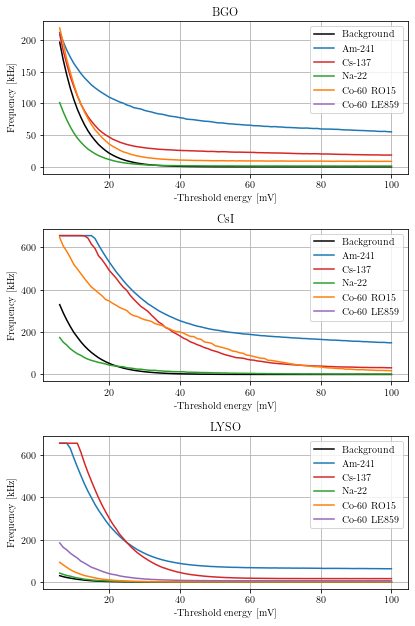

In [380]:
df['noise_signal_ratio'] = df.frequency / df.frequency_no_source

fig = plt.figure(figsize=set_size(424, fraction=1, shape=(3,1)))
axs = fig.subplots(3,1)
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']

for (ax, crystal) in zip(axs, crystals):
    df_crystal = df[df.crystal == crystal]
    ax.plot(-df_crystal.threshold_energy[:95], df_crystal.frequency_no_source[:95], label='Background', color='black')

    for (color, source) in zip(colors, sources):
        df_source = df_crystal[df_crystal.source == source]
        ax.plot(-df_source.threshold_energy[:95], df_source.frequency[:95], label=source, color=color)
    ax.set_xlabel('-Threshold energy [mV]')
    ax.set_ylabel('Frequency [kHz]')
    ax.legend()
    ax.grid(True)
    ax.set_title(crystal)
    ax.set_yscale('linear')

fig.tight_layout()
fig.savefig(figure_path + 'snr.pdf')

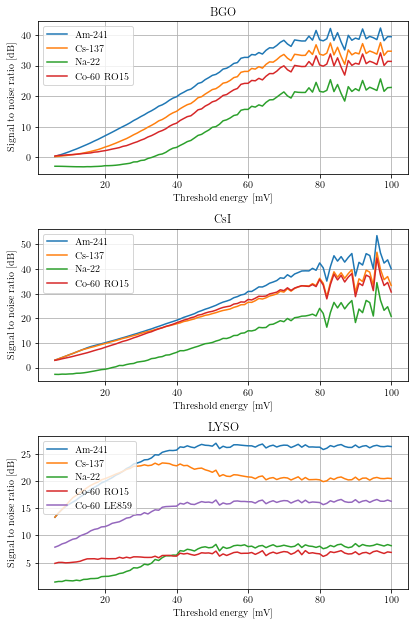

In [381]:
df['noise_signal_ratio'] = df.frequency / df.frequency_no_source

fig = plt.figure(figsize=set_size(424, fraction=1, shape=(3,1)))
axs = fig.subplots(3,1)

for (ax, crystal) in zip(axs, crystals):
    df_crystal = df[df.crystal == crystal]
    for source in sources:
        df_source = df_crystal[df_crystal.source == source]
        energy = df_source.threshold_energy
        noise_signal_ratio = df_source.noise_signal_ratio

        if len(energy != 0):
            ax.plot(-df_source.threshold_energy[:95], 10*np.log10(df_source.noise_signal_ratio[:95]), label=source)
        ax.legend()
        ax.set_title(crystal)
        # ax.set_yscale('log')
        ax.set_xlabel('Threshold energy [mV]')
        ax.set_ylabel('Signal to noise ratio [dB]')
        ax.grid(True)

fig.tight_layout()
fig.savefig(figure_path + 'thresholds.pdf')

In [382]:
thresholds = [70, 80, 60]

df_frequencies = pd.DataFrame()
for (crystal, threshold) in zip(crystals, thresholds):
    df_to_append = df[(df.threshold_energy == -threshold) & (df.crystal == crystal)]
    df_frequencies = df_frequencies.append(df_to_append)
df_frequencies[['frequency', 'frequency_no_source']] = df_frequencies[['frequency', 'frequency_no_source']] * 10**3
df_frequencies

,crystal,date,source,threshold_energy,frequency,frequency_no_source,noise_signal_ratio
64,BGO,27-07-21,Am-241,-70,62131.000,9.33333,6656.895235
159,BGO,27-07-21,Cs-137,-70,21493.000,9.33333,2302.822251
254,BGO,30-07-21,Na-22,-70,1283.670,9.33333,137.536121
449,BGO,30-07-21,Co-60 RO15,-70,9109.670,9.33333,976.036420
654,CsI,27-07-21,Am-241,-80,165214.000,9.33333,17701.506322
749,CsI,27-07-21,Cs-137,-80,39205.000,9.33333,4200.537214
844,CsI,29-07-21,Na-22,-80,2363.670,9.33333,253.250448
1039,CsI,29-07-21,Co-60 RO15,-80,35254.300,9.33333,3777.247778
1214,LYSO,27-07-21,Am-241,-60,68055.700,154.00000,441.920130
1309,LYSO,27-07-21,Cs-137,-60,18279.300,154.00000,118.696753


In [383]:
df_activities = pd.DataFrame(
    [
        ['Am-241', 0.427, '01-12-1986', 432.60],
        ['Cs-137', 0.424, '01-06-1984', 30.08],
        ['Na-22', 4.8, '23-08-2001', 2.60],
        ['Co-60 RO15', 3.67, '18-12-2002', 5.27],
        ['Co-60 LE859', 7.4, '15-09-1981', 5.27]
    ],
    columns=['source', 'initial_activity', 'date', 'half_life']
)
df_activities['half_life'] = df_activities['half_life'] * 365
df_activities['energy'] = [48.946452112049364, 123.96591809974102, 511.00600000000003, 631.5763623147884, 481.3091598712078,]
df_activities

,source,initial_activity,date,half_life,energy
0,Am-241,0.427,01-12-1986,157899.00,48.946452
1,Cs-137,0.424,01-06-1984,10979.20,123.965918
2,Na-22,4.800,23-08-2001,949.00,511.006000
3,Co-60 RO15,3.670,18-12-2002,1923.55,631.576362
4,Co-60 LE859,7.400,15-09-1981,1923.55,481.309160


In [384]:
df_activities['date'] = pd.to_datetime(df_activities.date, format='%d-%m-%Y')

In [385]:
df_activities['time'] = (pd.Timestamp(year=2021, month=7, day=1) - df_activities['date']).dt.days
df_activities['initial_activity'] = df_activities['initial_activity'] * 10**6

df_activities

,source,initial_activity,date,half_life,energy,time
0,Am-241,427000.0,1986-12-01,157899.00,48.946452,12631
1,Cs-137,424000.0,1984-06-01,10979.20,123.965918,13544
2,Na-22,4800000.0,2001-08-23,949.00,511.006000,7252
3,Co-60 RO15,3670000.0,2002-12-18,1923.55,631.576362,6770
4,Co-60 LE859,7400000.0,1981-09-15,1923.55,481.309160,14534


In [386]:
A0 = df_activities['initial_activity'].to_numpy()
t = df_activities['time'].to_numpy()
tau = df_activities['half_life'].to_numpy() / np.log(2)

df_activities['activity'] = A0 * np.exp(-t / tau)
df_activities.loc[3:5, 'activity'] = df_activities.loc[3:5, 'activity'] * 2
df_activities

,source,initial_activity,date,half_life,energy,time,activity
0,Am-241,427000.0,1986-12-01,157899.00,48.946452,12631,403968.246626
1,Cs-137,424000.0,1984-06-01,10979.20,123.965918,13544,180307.436776
2,Na-22,4800000.0,2001-08-23,949.00,511.006000,7252,24035.427448
3,Co-60 RO15,3670000.0,2002-12-18,1923.55,631.576362,6770,640045.276092
4,Co-60 LE859,7400000.0,1981-09-15,1923.55,481.309160,14534,78656.183827


In [387]:
df_efficiency = df_frequencies.merge(df_activities, how='left', left_on='source', right_on='source')
df_efficiency['efficiency'] = df_efficiency['frequency'] / df_efficiency['activity']
df_efficiency['intrinsic_efficiency'] = df_efficiency['efficiency'] * 2
df_efficiency

,crystal,date_x,source,threshold_energy,frequency,frequency_no_source,noise_signal_ratio,initial_activity,date_y,half_life,energy,time,activity,efficiency,intrinsic_efficiency
0,BGO,27-07-21,Am-241,-70,62131.000,9.33333,6656.895235,427000.0,1986-12-01,157899.00,48.946452,12631,403968.246626,0.153802,0.307603
1,BGO,27-07-21,Cs-137,-70,21493.000,9.33333,2302.822251,424000.0,1984-06-01,10979.20,123.965918,13544,180307.436776,0.119202,0.238404
2,BGO,30-07-21,Na-22,-70,1283.670,9.33333,137.536121,4800000.0,2001-08-23,949.00,511.006000,7252,24035.427448,0.053407,0.106815
3,BGO,30-07-21,Co-60 RO15,-70,9109.670,9.33333,976.036420,3670000.0,2002-12-18,1923.55,631.576362,6770,640045.276092,0.014233,0.028466
4,CsI,27-07-21,Am-241,-80,165214.000,9.33333,17701.506322,427000.0,1986-12-01,157899.00,48.946452,12631,403968.246626,0.408978,0.817955
5,CsI,27-07-21,Cs-137,-80,39205.000,9.33333,4200.537214,424000.0,1984-06-01,10979.20,123.965918,13544,180307.436776,0.217434,0.434868
6,CsI,29-07-21,Na-22,-80,2363.670,9.33333,253.250448,4800000.0,2001-08-23,949.00,511.006000,7252,24035.427448,0.098341,0.196682
7,CsI,29-07-21,Co-60 RO15,-80,35254.300,9.33333,3777.247778,3670000.0,2002-12-18,1923.55,631.576362,6770,640045.276092,0.055081,0.110162
8,LYSO,27-07-21,Am-241,-60,68055.700,154.00000,441.920130,427000.0,1986-12-01,157899.00,48.946452,12631,403968.246626,0.168468,0.336936
9,LYSO,27-07-21,Cs-137,-60,18279.300,154.00000,118.696753,424000.0,1984-06-01,10979.20,123.965918,13544,180307.436776,0.101379,0.202757


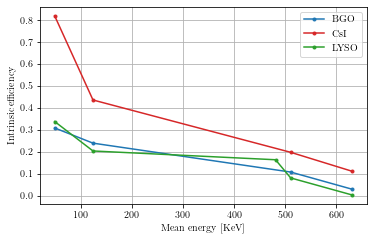

In [388]:
colors = ['tab:blue', 'tab:red', 'tab:green']
fig = plt.figure(figsize=set_size(424))
ax = fig.add_subplot()

def linear(x, m):
    return m*x
for (crystal, color) in zip(crystals, colors):
    df_crystal = df_efficiency[df_efficiency.crystal == crystal]
    energy = df_crystal['energy']
    intrinsic_efficiency = df_crystal['intrinsic_efficiency']
    energy, intrinsic_efficiency = zip(*sorted(zip(energy, intrinsic_efficiency)))
    #par, cov = optimize.curve_fit(linear, frequency, intrinsic_efficiency)

    ax.plot(energy, intrinsic_efficiency, color=color, marker='.', label=crystal)
ax.grid(True)
ax.set_xlabel('Mean energy [KeV]')
ax.set_ylabel('Intrinsic efficiency')
ax.legend()
fig.savefig(figure_path + 'efficiency.pdf')

In [389]:
print(df_efficiency.to_latex(
    columns=['crystal', 'threshold_energy', 'source', 'efficiency', 'intrinsic_efficiency'],
    header=['Crystal', 'Threshold energy [mV]', 'Source', 'Efficiency', 'Intrinsic efficiency'],
    index=False, multirow=True
))

\begin{tabular}{lllrr}
\toprule
Crystal & Threshold energy [mV] &      Source & Efficiency & Intrinsic efficiency \\
\midrule
    BGO &                   -70 &      Am-241 &   0.153802 &             0.307603 \\
    BGO &                   -70 &      Cs-137 &   0.119202 &             0.238404 \\
    BGO &                   -70 &       Na-22 &   0.053407 &             0.106815 \\
    BGO &                   -70 &  Co-60 RO15 &   0.014233 &             0.028466 \\
    CsI &                   -80 &      Am-241 &   0.408978 &             0.817955 \\
    CsI &                   -80 &      Cs-137 &   0.217434 &             0.434868 \\
    CsI &                   -80 &       Na-22 &   0.098341 &             0.196682 \\
    CsI &                   -80 &  Co-60 RO15 &   0.055081 &             0.110162 \\
   LYSO &                   -60 &      Am-241 &   0.168468 &             0.336936 \\
   LYSO &                   -60 &      Cs-137 &   0.101379 &             0.202757 \\
   LYSO &               